# Data preprocessing
----
- Basic information about the dataset,
- Examination of anomalies or inconsistencies,
- Preprocessing of the data based on the observed issues.

In [15]:
import numpy as np
import pandas as pd

### Training dataset
- We're modelling the "Sales" variable, reflecting the turnover during a specific date.

### Testing dataset
- The testing dataset is available on kaggle, but it doesn't contain the actual sales (for computing the MSE, for example), so we will create our own.

In [16]:
train_data = pd.read_csv("data/train.csv")
store_data = pd.read_csv("data/store.csv")

/tmp/ipykernel_54033/3856619876.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv("data/train.csv")


In [17]:
print("Train data dimensions:", train_data.shape)
print("Additional information about the stores dimensions:", store_data.shape)

Train data dimensions: (1017209, 9)
Additional information about the stores dimensions: (1115, 10)


In [18]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [19]:
# Some features are not encoded well
print(train_data.StateHoliday.unique()) # Because of the string "0" and the integer 0, python saves this as an "object" structure
train_data.StateHoliday = train_data.StateHoliday.astype(str)
print(train_data.StateHoliday.unique())

['0' 'a' 'b' 'c' 0]
['0' 'a' 'b' 'c']


In [20]:
print(train_data.Date.head())
# Because the "Date" is also saved as an object, we can look for any non-string values in the variable
print(train_data.Date[~train_data.Date.apply(lambda x: isinstance(x, str))]) # Luckily there's none

train_data.Date = pd.to_datetime(train_data.Date)

0    2015-07-31
1    2015-07-31
2    2015-07-31
3    2015-07-31
4    2015-07-31
Name: Date, dtype: object
Series([], Name: Date, dtype: object)


In [21]:
print(train_data.isna().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64


### Now that the dataset is clean, we move onto the store specifics

In [22]:
store_data.info()
store_data.isna().sum() # Many missing values, some intentionally left blank

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [23]:
store_data = pd.read_csv("data/store.csv")

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval


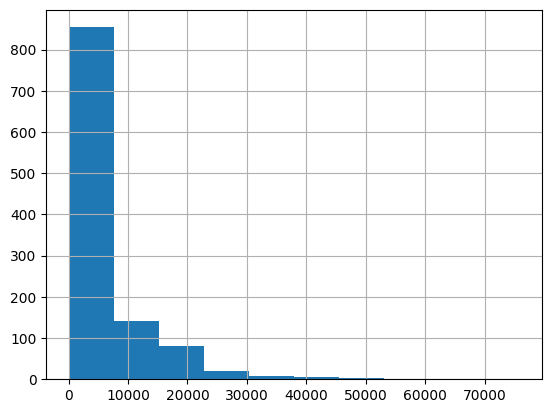

In [24]:
display(store_data[store_data.CompetitionDistance.isna()]) # Only 3 stores, safe to impute using mean or median
store_data.CompetitionDistance.hist() # Severly skewed
store_data[store_data.CompetitionDistance == 0] # No zeros, so we can use log

Median = 7.751 and mean = 7.644


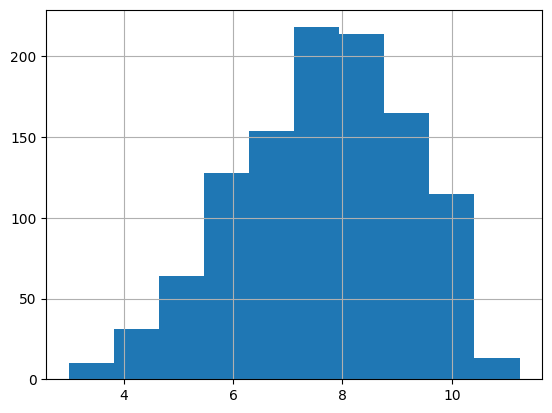

In [25]:
store_data["LogCompetitionDistance"] = np.log(store_data.CompetitionDistance) # Log-transforming works well
print(f"Median = {store_data.LogCompetitionDistance.median():.3f} and mean = {store_data.LogCompetitionDistance.mean():.3f}") # Stable
store_data.LogCompetitionDistance.hist()

# Impute the values using the mean
na_indexes_comp_distance = store_data[store_data.CompetitionDistance.isna()].index
store_data.loc[na_indexes_comp_distance, "LogCompetitionDistance"] = store_data.LogCompetitionDistance.mean()

In [26]:
store_data.loc[store_data.CompetitionOpenSinceYear < 1950, "CompetitionOpenSinceYear"] = float("nan") # Some stores have impossible values (competition opening in 1900)

# Merge the store dataset into the original data
train_data = train_data.merge(store_data, on="Store", how="left")

In [27]:
display(store_data[store_data.CompetitionOpenSinceMonth.isna()].head(3))

print("Train data last date:", train_data.Date.max()) # Note the last actual datapoint being July the 31st

# New variable that describes total number of months open (competition) - relative to the specific date
train_data["CompetitionMonthsTotal"] = (
    (train_data.Date.dt.year - train_data.CompetitionOpenSinceYear) * 12 + 
    (train_data.Date.dt.month - train_data.CompetitionOpenSinceMonth))

train_data["CompetitionMonthsKnown"] = ~train_data.CompetitionMonthsTotal.isna() * 1

# Another variable describing the total months of active promo - number of weeks has to be standardized to months
train_data["Promo2MonthsTotal"] = (
    (train_data.Date.dt.year - train_data.Promo2SinceYear) * 12 + 
    (train_data.Date.dt.isocalendar().week - train_data.Promo2SinceWeek) / 4)

# These variables can easily be negative, e.g. the store data is from 2014-05-01, but the competition (or promo),
# began at 2015-01-01
# 
# Easily solved by setting all the negative values to 0 

train_data.loc[train_data.CompetitionMonthsTotal < 0, "CompetitionMonthsTotal"] = 0
train_data.loc[train_data.Promo2MonthsTotal < 0, "Promo2MonthsTotal"] = 0

display(train_data.head(3))

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,LogCompetitionDistance
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct",6.975414
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov",5.736572
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN,8.092545


Train data last date: 2015-07-31 00:00:00


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,LogCompetitionDistance,CompetitionMonthsTotal,CompetitionMonthsKnown,Promo2MonthsTotal
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,7.146772,82.0,1,<NA>
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",6.345636,92.0,1,64.5
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",9.556055,103.0,1,52.25


In [28]:
# The last untouched variable is the PromoInterval
# This is tricky, because we can use the interval itself to check if the store has a promo on a specific date
# Or, on the other hand, we can check for seasonality promos (like full summer promos performing better)

display(train_data.PromoInterval.unique())

# For now, creating the current promo status is enough, as there's only 3 different groups of intervals
# (not diverse enough to warrant a deeper usage of the variable)

month_to_number = {
    "Jan": 1, "Feb": 2, "Mar": 3,
    "Apr": 4, "May": 5, "Jun": 6,
    "Jul": 7, "Aug": 8, "Sept": 9,
    "Oct": 10, "Nov": 11, "Dec": 12
}

def promo_currently_going_on(row):
    list_of_months = []
    if pd.isna(row.PromoInterval):
        return float("nan")
    for month in row.PromoInterval.split(","):
        list_of_months.append(month_to_number[month])
    
    return int((row.Date.month in list_of_months) * 1)

train_data["Promo2CurrentlyOn"] = train_data.apply(promo_currently_going_on, axis=1)

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [29]:
# Lastly the extraction of 'Date', so that it may be used in actual modelling

train_data["Year"] = train_data.Date.dt.year
train_data["Month"] = train_data.Date.dt.month
train_data["Week"] = train_data.Date.dt.isocalendar().week

In [30]:
train_clean = train_data[["Sales", "Customers", "Store", "Date", "DayOfWeek", "Week", "Month", "Year", 
                          "Open", "Promo", "StateHoliday", "SchoolHoliday", "StoreType",
                          "Assortment", "LogCompetitionDistance", "CompetitionMonthsKnown", "CompetitionMonthsTotal",
                          "Promo2", "Promo2MonthsTotal", "Promo2CurrentlyOn"]].copy() 

In [31]:
train_clean.isna().sum()

Sales                          0
Customers                      0
Store                          0
Date                           0
DayOfWeek                      0
Week                           0
Month                          0
Year                           0
Open                           0
Promo                          0
StateHoliday                   0
SchoolHoliday                  0
StoreType                      0
Assortment                     0
LogCompetitionDistance         0
CompetitionMonthsKnown         0
CompetitionMonthsTotal    324106
Promo2                         0
Promo2MonthsTotal         508031
Promo2CurrentlyOn         508031
dtype: int64

In [32]:
# Only 3 columns have empty values, all of these have a dummy value, that tells the model if there's a competition or a promo
display(train_clean.loc[:, train_clean.isna().sum() != 0].head())

train_clean.loc[:, train_clean.isna().sum() != 0] = train_clean.loc[:, train_clean.isna().sum() != 0].fillna(0)
train_clean["CompetitionMonthsTotal"] = train_clean["CompetitionMonthsTotal"].astype(int)
train_clean["Promo2CurrentlyOn"] = train_clean["Promo2CurrentlyOn"].astype(int)

print(train_clean.isna().sum())

,CompetitionMonthsTotal,Promo2MonthsTotal,Promo2CurrentlyOn
0,82.0,<NA>,NaN
1,92.0,64.5,1.0
2,103.0,52.25,1.0
3,70.0,<NA>,NaN
4,3.0,<NA>,NaN


Sales                     0
Customers                 0
Store                     0
Date                      0
DayOfWeek                 0
Week                      0
Month                     0
Year                      0
Open                      0
Promo                     0
StateHoliday              0
SchoolHoliday             0
StoreType                 0
Assortment                0
LogCompetitionDistance    0
CompetitionMonthsKnown    0
CompetitionMonthsTotal    0
Promo2                    0
Promo2MonthsTotal         0
Promo2CurrentlyOn         0
dtype: int64


In [33]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   Sales                   1017209 non-null  int64         
 1   Customers               1017209 non-null  int64         
 2   Store                   1017209 non-null  int64         
 3   Date                    1017209 non-null  datetime64[ns]
 4   DayOfWeek               1017209 non-null  int64         
 5   Week                    1017209 non-null  UInt32        
 6   Month                   1017209 non-null  int32         
 7   Year                    1017209 non-null  int32         
 8   Open                    1017209 non-null  int64         
 9   Promo                   1017209 non-null  int64         
 10  StateHoliday            1017209 non-null  object        
 11  SchoolHoliday           1017209 non-null  int64         
 12  StoreType     

In [34]:
# Quick reformatting of irregular types of values
train_clean["Promo2MonthsTotal"] = train_clean["Promo2MonthsTotal"].astype(float)
train_clean["Week"] = train_clean["Week"].astype("int32")
train_clean["StateHoliday"] = train_clean["StateHoliday"].astype("category")
train_clean["StoreType"] = train_clean["StoreType"].astype("category")
train_clean["Assortment"] = train_clean["Assortment"].astype("category")

display(train_clean.head(3))
train_clean.info()

,Sales,Customers,Store,Date,DayOfWeek,Week,Month,Year,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,LogCompetitionDistance,CompetitionMonthsKnown,CompetitionMonthsTotal,Promo2,Promo2MonthsTotal,Promo2CurrentlyOn
0,5263,555,1,2015-07-31,5,31,7,2015,1,1,0,1,c,a,7.146772,1,82,0,0.00,0
1,6064,625,2,2015-07-31,5,31,7,2015,1,1,0,1,a,a,6.345636,1,92,1,64.50,1
2,8314,821,3,2015-07-31,5,31,7,2015,1,1,0,1,a,a,9.556055,1,103,1,52.25,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   Sales                   1017209 non-null  int64         
 1   Customers               1017209 non-null  int64         
 2   Store                   1017209 non-null  int64         
 3   Date                    1017209 non-null  datetime64[ns]
 4   DayOfWeek               1017209 non-null  int64         
 5   Week                    1017209 non-null  int32         
 6   Month                   1017209 non-null  int32         
 7   Year                    1017209 non-null  int32         
 8   Open                    1017209 non-null  int64         
 9   Promo                   1017209 non-null  int64         
 10  StateHoliday            1017209 non-null  category      
 11  SchoolHoliday           1017209 non-null  int64         
 12  StoreType     

In [35]:
train_clean.to_pickle("train_clean.pkl")